In [232]:
%pylab inline
import scipy.special
import seaborn as sns
from yapf.yapflib.yapf_api import FormatCode

Populating the interactive namespace from numpy and matplotlib


In [206]:
class ratmoving:
    
    def __init__(self,n,L):
        self.n=n #linear dimension
        self.L=L #lenght of the grid
        self.N=n*n #number of neurons
        self.sigma=1*float(L/n) 
        self.c=1*float(L/n)*5 #cutoff
        self.grid=zeros((pow(n,2),2)) #firing places' grid
        self.J=zeros((n*n,n*n)) #connettivity matrix
        self.hebbJ=zeros((n*n,n*n)) #hebbian CM 
        self.V=zeros(n*n) #activity of the network
    
    
    def ambient(self,l):#n=square root of number of neurons, l=randomness ,L dimension
        for i in range(self.n):
            for j in range(self.n):
                self.grid[self.n*i+j][0]=random.uniform(float(self.L)/float(self.n)*(i),float(self.L)/float(self.n)*(i+l))
                self.grid[self.n*i+j][1]=random.uniform(float(self.L)/float(self.n)*(j),float(self.L)/float(self.n)*(j+l))
        return         
    
    def computeV(self,currentposition): #computes the activity of the network depending on the current position of the external input
        for i in range(self.N):
                self.V[i]=kernel(self.grid[i],currentposition,self.sigma,rat.c)
    
    def strenght(self,currentposition,eta): #upgrades CM with a learning rate eta dep. on the activity, fills J
        deltaJ=zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                if j!=i:
                    deltaJ[i][j]=eta*(self.V[i])*(self.V[j]) 
                else:
                    deltaJ[i][j]=0
                    
        for i in range(self.N):
            for j in range(self.N):
                self.J[i][j]=self.J[i][j]+deltaJ[i][j]
        #a=sum(self.J)
        #self.J=self.J/a
        self.J=self.J/norm(self.J)
            
    def learn(self,path,eta,A): #total learning of the CM in t steps of a path
        et=eta
        t=path.shape[0]
        m=zeros(t)
        for s in range(t):
            self.computeV(path[s]) #compute V on the current position of path's
            self.strenght(path[s],et) #reinforcement of CM
            m[s]=overlap(self.J,A) #evaluates overlap between J and A
            if s%100==0:
                print(s)
        plot(np.arange(t),m) #plots overlap over t
        xlabel('t')
        ylabel('overlap')
        show()
        return m
           
            
    
    def zerostrenght(self): #generates a starting randm uniform CM
        for i in range(self.N):
            for j in range(self.N):
                self.J[i][j]=random.randint(0,10,size=1)
        #a=sum(self.J)
        #self.J=self.J/a
        self.J=self.J/norm(self.J)
       
        
    def hebbstrenght(self): #generates an hebbian CM
        for i in range(self.N):
            for j in range(self.N):
                self.hebbJ[i][j]=kernel(self.grid[i],self.grid[j],self.sigma,self.c)
        #a=sum(self.hebbJ)
        #self.hebbJ=self.hebbJ/a
        self.hebbJ=self.hebbJ/norm(self.hebbJ)
        

    def random_trajectory(self,t):#x=storage position vector, t=time steps
        x=zeros((t,2))
        col=arange(t)
        x[0][0]=random.uniform(0,self.L)
        x[0][1]=random.uniform(0,self.L)
        #x[0][0]=0.1
        #x[0][1]=0.1
        theta=zeros(t)
        theta[0]=random.uniform(0,2*pi)
        
        for i in range(1,t):
            x[i][0]=x[i-1][0]+0.5*(self.L/float(self.n))*cos(theta[i-1])
            x[i][1]=x[i-1][1]+0.5*(self.L/float(self.n))*sin(theta[i-1])
            theta[i]=random.normal(theta[i-1],pi/2,1)    
            
            if logical_or(x[i][0]>self.L,x[i][0]<0):
                theta[i-1]=pi-theta[i-1]
                x[i][0]=x[i-1][0]+0.5*(self.L/float(self.n))*cos(theta[i-1])
            if logical_or(x[i][1]>self.L,x[i][1]<0):
                theta[i-1]=-theta[i-1]
                x[i][1]=x[i-1][1]+0.5*(self.L/float(self.n))*sin(theta[i-1])
        #scatter(x.T[0],x.T[1],c=col,cmap=cm.jet)        
        return x   
            
        #genera traiettoria random con hard bounds e inerzia direzonale
        
        
    def ordered_trajectory(self,t):
        x[0][0]=random.randint(0,self.N)
        x[0][1]=random.randint(0,self.N)
        while (x[i][0]==self.n and i<t):
            x[i+1][0]=x[i][0]+random.choice([-1,0,1],size=1,p=[1/3,1/3,1/3])
            x[i+1][1]=x[i][1]
            
    def sample_regular_grid(self,epochs): #genera traiettoria random. ciascun neurone viene visitato epochs volte. 
        x=[]
        pos=np.zeros((self.N,2))
        for i in range(self.n):
            for j in range(self.n):
                pos[self.n*i+j][0]=i*(self.L/float(self.n))
                pos[self.n*i+j][1]=j*(self.L/float(self.n))
        for e in range(epochs):
            np.random.shuffle(pos)
            x.append(pos)
        return np.asarray(x).reshape((self.N*epochs,2))
    
   
        


In [226]:
def kernel(r_i,r_r,sig,c):#r_i=position on the grid,r_r=rat position,sig=standard deviation,c=cutoff
        V=0.0  
        dx=0
        dy=0
        d=0
        dx=abs(r_i[0]-r_r[0])
        dy=abs(r_i[1]-r_r[1])
        d=sqrt(pow(dx,2)+pow(dy,2))
        if d<=c:
            #V=sqrt(2/(pi*pow(sig,2)))*float(1/erf(float(c)/sqrt(2*pow(sig,2))))*exp(-0.5*pow(d/sig,2))
            V=exp(-0.5*pow(d/sig,2))
        else:
            V=0    
        return V
    
def overlap(matA,matB):
    m=0
    for i in range(matA.shape[0]):
        for j in range(matA.shape[0]):
                m=m+matA[i][j]*matB[i][j]
    m=m/float(norm(matA)*norm(matB))
    return m

def distance(r_1,r_2):
    dx=0
    dy=0
    d=0
    dx=abs(r_1[0]-r_2[0])
    dy=abs(r_1[1]-r_2[1])
    d=sqrt(pow(dx,2)+pow(dy,2))
    return d

#transfer function
def f(h,th,g):
    if (h-th)>0:
        return g*(h-th)
    else:
        return 0.0
    
def positive_mean(v,th):
    return mean([x-th for x in v if x-th>0])

#interaction kernel

def fix_parameters(V1,h1,th,a,a2):
    fixed=False
    it=0
    while (not fixed) and it<maxiter:
        th=th+b*(pow(mean(V1),2)/mean(pow(V1,2))-a2)
        V1=asarray(list(map(lambda h1: f(h1,th,g),h1)))
        fixed=(abs((pow(mean(V1),2)/mean(pow(V1,2))-a2))/a2 <= sigma_mean)
    #g=a/positive_mean(h1,th)
    if it>=maxiter:
        print("Iter bound reached")
    return th

def dynamic(position,J,mapping): #evolves the activity with J starting from a bump in current position
    #parameters
    N=len(mapping[0])                           
    xi=0.2                    
    maxsteps=50
    a=1.0 #mean activity
    a2=0.1 #sparsity

#for threshold fixing
    b=0.01
    sigma_mean=0.001
    maxiter=10000000
    lmbd=10
#initialization
    V=zeros(N)
    h=zeros(N)
    Vin=zeros(N)

    rat.computeV(position)
    V=rat.V
    Vin=V
    
    g=1.1
    th=0
    for step in range(maxsteps):
        h=dot(J,V)
        V=asarray(list(map(lambda h: f(h,th,g),h)))
        th=fix_parameters(V,h,th,a,a2)
        V=asarray(list(map(lambda h: f(h,th,g),h)))
        g=a/mean(V)
        V=g*V
    index=where(V==max(V))  
    return mapping[index[0]][0]
    #print("Dynamic step: "+str(step)+" done, mean: "+str(mean(V))+" sparsity: "+str(pow(mean(V),2)/mean(pow(V,2))))


def J_txt(A,l,eta,epochs): #prints J in a .txt reporting the trajectory,learning rate and epochs of the learning
    B=matrix(A)
    name_of_file="J("+str(l)+","+str(eta)+","+str(epochs)+")"
    file=open(name_of_file + ".txt","w+")
    for line in B:
        savetxt(file,line,fmt='%.2f')
    file.close()  

In [208]:
rat=ratmoving(20,100)
rat.ambient(0)

In [209]:
rat.hebbstrenght()
rat.zerostrenght()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600


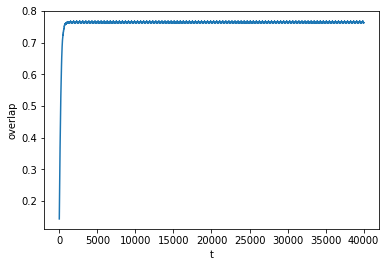

array([0.14380657, 0.14638177, 0.14909872, ..., 0.76323033, 0.76327486,
       0.76278527])

In [210]:
x=rat.sample_regular_grid(100)
rat.learn(x,0.01,rat.hebbJ)

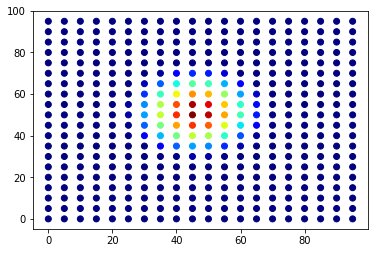

In [214]:
scatter(rat.grid.T[0],rat.grid.T[1],c=V,cmap=cm.jet)

In [215]:
niter=5
nr=5
ncells=nr*nr
unit=rat.L/(2*float(nr))
spacing=rat.L/(float(nr))
centers=zeros((ncells,2))
xv=linspace(unit,rat.L-unit,nr)
yv=linspace(unit,rat.L-unit,nr)

freq=zeros((nr,nr,ncells))

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[2 0]
[2 0]
[2 0]
[0 1]
[2 0]
[2 0]
[2 0]
[3 0]
[2 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[0 1]
[0 2]
[0 1]
[0 2]
[0 1]
[1 1]
[1 1]
[1 1]
[0 2]
[1 1]
[2 0]
[3 0]
[3 0]
[2 0]
[2 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[3 0]
[0 2]
[0 2]
[0 2]
[0 2]
[0 2]
[0 2]
[0 2]
[2 3]
[2 3]
[0 2]
[2 3]
[2 3]
[3 3]
[2 3]
[2 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[1 3]
[0 2]
[1 3]
[0 2]
[0 2]
[2 3]
[1 3]
[1 3]
[2 3]
[1 3]
[3 3]
[3 3]
[1 3]
[2 3]
[2 3]
[3 3]
[3 4]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[1 3]
[1 3]
[1 3]
[1 3]
[1 3]
[1 3]
[1 3]
[1 3]
[1 3]
[1 3]
[1 3]
[3 4]
[3 4]
[3 4]
[3 4]
[3 3]
[3 4]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]
[3 3]


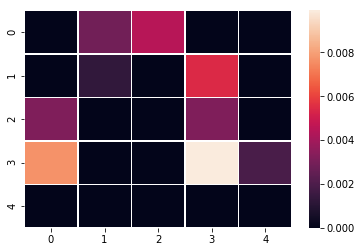

In [216]:
for j in range(nr):
    for i in range(nr):
        for t in range(niter):
            loc=zeros(2)
            arrival=zeros(2)
            r=zeros(2)
            loc[0]=random.uniform(xv[i]-unit,xv[i]+unit)
            loc[1]=random.uniform(yv[j]-unit,yv[j]+unit)
            r=dynamic(loc,rat.J,rat.grid)
            arrival[0]=r[0]//spacing
            arrival[1]=r[1]//spacing
            arrival=arrival.astype(int)
            print(arrival)
            freq[arrival[0]][arrival[1]][i+j]=freq[arrival[0]][arrival[1]][i+j]+1
meanf=zeros((nr,nr))
tot=sum(freq)
for i in range(nr):
    for j in range(nr):
        meanf[i][j]=mean(freq[i][j])/tot
ax = sns.heatmap(meanf, linewidths=.5)        


In [ ]:
ax = sns.heatmap(meanf, linewidths=.5)

In [230]:
J_txt(rat.J,"srg",0.01,100)